## Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/news-summary/news_summary_more.csv
/kaggle/input/news-summary/news_summary.csv


In [2]:
!pip install rouge

In [4]:
import os
import re
import nltk
import torch
import datasets
import numpy as np
import pandas as pd
from rouge import Rouge
import matplotlib.pyplot as plt
from datasets import DatasetDict
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,

)
from huggingface_hub import notebook_login


In [5]:
notebook_login()

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Importing and creating dataset

In [7]:
df = pd.read_csv("/kaggle/input/news-summary/news_summary.csv", encoding='iso-8859-1')
df_raw = pd.read_csv("/kaggle/input/news-summary/news_summary_more.csv", encoding='iso-8859-1')

In [8]:
df

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...
...,...,...,...,...,...,...
4509,Mansha Mahajan,"24 Feb 2017,Friday",Rasna seeking ?250 cr revenue from snack categ...,http://indiatoday.intoday.in/story/rasna-eyes-...,Fruit juice concentrate maker Rasna is eyeing ...,"Mumbai, Feb 23 (PTI) Fruit juice concentrate m..."
4510,Dishant Sharma,"03 Aug 2017,Thursday",Sachin attends Rajya Sabha after questions on ...,http://indiatoday.intoday.in/story/sachin-tend...,Former Indian cricketer Sachin Tendulkar atten...,Former cricketer Sachin Tendulkar was spotted ...
4511,Tanya Dhingra,"03 Aug 2017,Thursday",Shouldn't rob their childhood: Aamir on kids r...,http://www.hindustantimes.com/bollywood/secret...,"Aamir Khan, while talking about reality shows ...","Aamir Khan, whose last film Dangal told the st..."
4512,Pragya Swastik,"07 Dec 2016,Wednesday","Asha Bhosle gets ?53,000 power bill for unused...",http://indiatoday.intoday.in/story/singer-asha...,The Maharashtra government has initiated an in...,Maharahstra Power Minister Chandrashekhar Bawa...


In [9]:
cnt = 0
for text in df['ctext']:
  if isinstance(text, float):
    cnt += 1
print(cnt)

118


In [10]:
df = df.dropna()

In [11]:
max_headlines_words = max([len(list(headline.split(" "))) for headline in df['headlines']])
max_text_words = max([len(list(text.split(" "))) for text in df['text']])
max_ctext_words = max([len(list(ctexts.split(" "))) for ctexts in df['ctext']])

print(max_headlines_words)
print(max_text_words)
print(max_ctext_words)

14
62
12201


In [12]:
complete_dataset = pd.DataFrame()
complete_dataset['text'] = df['ctext']
complete_dataset['summary'] = df['text']
complete_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4396 entries, 0 to 4513
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     4396 non-null   object
 1   summary  4396 non-null   object
dtypes: object(2)
memory usage: 103.0+ KB


In [13]:
complete_dataset.head()

,text,summary
0,The Daman and Diu administration on Wednesday ...,The Administration of Union Territory Daman an...
1,"From her special numbers to TV?appearances, Bo...",Malaika Arora slammed an Instagram user who tr...
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Mumbai and other Indian cities are t...,Hotels in Maharashtra will train their staff t...


## Data Cleaning

In [14]:
nltk.data.path.append('/kaggle/working/nltk_data')

# Download the necessary NLTK data
nltk.download('wordnet', download_dir='/kaggle/working/nltk_data')
nltk.download('omw-1.4', download_dir='/kaggle/working/nltk_data')
nltk.download('punkt', download_dir='/kaggle/working/nltk_data')


[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data] Downloading package punkt to /kaggle/working/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [15]:
import zipfile
import os

nltk_data_dir = '/kaggle/working/nltk_data/corpora'

# Extract the wordnet zip file
with zipfile.ZipFile(os.path.join(nltk_data_dir, 'wordnet.zip'), 'r') as zip_ref:
    zip_ref.extractall(os.path.join(nltk_data_dir))

# Extract the omw-1.4 zip file
with zipfile.ZipFile(os.path.join(nltk_data_dir, 'omw-1.4.zip'), 'r') as zip_ref:
    zip_ref.extractall(os.path.join(nltk_data_dir))

In [16]:
lemmatizer = WordNetLemmatizer()


def data_cleaning(column, column_name=""):
    data = []
    for row in column:
        
        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        #row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        row=re.sub(r"[<>()|&©ø\[\]\'\;~*]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        tokens = word_tokenize(row)
        lemmatized_row = ' '.join([lemmatizer.lemmatize(token) for token in tokens])
        data.append(lemmatized_row)

    data = pd.DataFrame({column_name: data})
    
    return data

In [17]:
brief_cleaning1 = data_cleaning(complete_dataset['text'], column_name='text')
brief_cleaning2 = data_cleaning(complete_dataset['summary'], column_name='summary')

In [ ]:
# brief_cleaning2['summary'] =  ["_START_ " + str(row) + " _END_" for row in brief_cleaning2['summary']]

In [18]:
brief_cleaning1['text'][0]

'the daman and diu administration on wednesday withdrew circular that asked woman staff to tie rakhis on male colleague after the order triggered backlash from employee and wa ripped apart on social media.the union territory ? s administration wa forced to retreat within 24 hour of issuing the circular that made it compulsory for it staff to celebrate rakshabandhan at workplace . ? it ha been decided to celebrate the festival of rakshabandhan on august in this connection , all offices/ department shall remain open and celebrate the festival collectively at suitable time wherein all the lady staff shall tie rakhis to their colleague , ? the order , issued on august by gurpreet singh , deputy secretary personnel had said.to ensure that no one skipped office , an attendance report wa to be sent to the government the next evening.the two notification one mandating the celebration of rakshabandhan left and the other withdrawing the mandate right were issued by the daman and diu administrati

In [19]:
brief_cleaning2['summary'][0]

'the administration of union territory daman and diu ha revoked it order that made it compulsory for woman to tie rakhis to their male colleague on the occasion of rakshabandhan on august the administration wa forced to withdraw the decision within 24 hour of issuing the circular after it received flak from employee and wa slammed on social medium .'

In [20]:
cleaned_complete_dataset = pd.DataFrame()
cleaned_complete_dataset['text'] = brief_cleaning1['text']
cleaned_complete_dataset['summary'] = brief_cleaning2['summary']
cleaned_complete_dataset.head()

,text,summary
0,the daman and diu administration on wednesday ...,the administration of union territory daman an...
1,"from her special number to tv ? appearance , b...",malaika arora slammed an instagram user who tr...
2,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...
3,lashkar-e-taiba kashmir commander abu dujana w...,"lashkar-e-taiba kashmir commander abu dujana ,..."
4,hotel in mumbai and other indian city are to t...,hotel in maharashtra will train their staff to...


In [21]:
text_count = []
summary_count = []

for sent in cleaned_complete_dataset['text']:
    text_count.append(len(sent.split()))
for sent in cleaned_complete_dataset['summary']:
    summary_count.append(len(sent.split()))

In [22]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

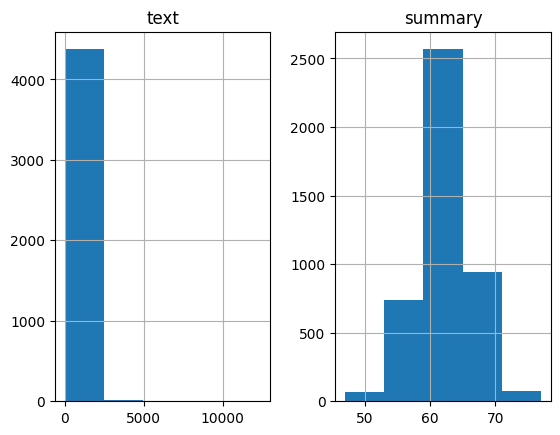

In [23]:
graph_df.hist(bins = 5)
plt.show()

In [24]:
max_text_len = 2500
max_summary_len = 70
print(max_text_len)
print(max_summary_len)

2500
70


In [25]:
cleaned_text =np.array(cleaned_complete_dataset['text'])
cleaned_summary=np.array(cleaned_complete_dataset['summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
cleaned_complete_dataset=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
#Add sostok and eostok at 
# cleaned_complete_dataset['summary'] = cleaned_complete_dataset['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [26]:
cleaned_complete_dataset.head()

,text,summary
0,the daman and diu administration on wednesday ...,the administration of union territory daman an...
1,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...
2,hotel in mumbai and other indian city are to t...,hotel in maharashtra will train their staff to...
3,an alleged suspect in kidnapping case wa found...,a 32-year-old man on wednesday wa found hangin...
4,"in an interesting ruling , the delhi high cour...",the delhi high court reduced the compensation ...


In [27]:
cleaned_complete_dataset.rename(columns={"text": "news"}, inplace = True)

## Creating Model

In [28]:
from sklearn.model_selection import train_test_split
# x_train,x_val,y_train,y_val=train_test_split(np.array(cleaned_complete_dataset['text']),np.array(cleaned_complete_dataset['summary']),test_size=0.1,random_state=0,shuffle=True)

In [29]:
# Converting the pandas dataset to huggingface dataset
# first split the train and test set
train_df, test_df = train_test_split(cleaned_complete_dataset, test_size=0.1, shuffle=True)
print("train and val shape:", train_df.shape, "test shape:",test_df.shape)
# save for every model inference
global_train_df = train_df
global_test_df = test_df
train_df = datasets.Dataset.from_pandas(train_df)
train_df = train_df.remove_columns(["__index_level_0__"])
# split train into train and val
train_df = train_df.train_test_split(test_size=0.2, shuffle=True) # split train and test
train_df["train"][0]

train and val shape: (3867, 2) test shape: (430, 2)


{'news': "by aditi khanna london , jun 28 pti secondary school in north-west england ha become the first in the uk to offer hijab or headscarf worn by muslim a part of the uniform for pupil sir john thursby community college in burnley , lancashire , reacted to concern that some hijab were being worn incorrectly by introducing uniform version however , the move ha come under fire from some muslim parent and pupil , who feel the uniform hijab are uncomfortable and not modest enough they have launched an online petition , signed by 150 people , protesting against the lack of consultation over the new uniformed hijab `` unfortunately , there wa very little consultation by parent or the girl attending the school consequently , scarf designed by the school ha been created it is very tight and in some case too short a some of the girl have long hair and so it defeat the object to wear it , '' the petition read it also question the `` real agenda '' behind the move and if it is to `` put girl

In [30]:
# Fitting into dataset dict
train_val_test_dataset = DatasetDict({
    'train': train_df["train"],
    'val': train_df['test']})

print(type(train_val_test_dataset))
train_val_test_dataset

<class 'datasets.dataset_dict.DatasetDict'>


DatasetDict({
    train: Dataset({
        features: ['news', 'summary'],
        num_rows: 3093
    })
    val: Dataset({
        features: ['news', 'summary'],
        num_rows: 774
    })
})

In [31]:
model_name = 'google-t5/t5-small'
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [32]:
def prepare_dataset(data):
    inputs = data["news"]
    model_inputs = tokenizer(inputs, max_length=2000, truncation=True)
    labels = tokenizer(text_target=data["summary"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [33]:
tokenized_data = train_val_test_dataset.map(prepare_dataset, batched=True)

Map:   0%|          | 0/3093 [00:00<?, ? examples/s]

Map:   0%|          | 0/774 [00:00<?, ? examples/s]

In [34]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['news', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3093
    })
    val: Dataset({
        features: ['news', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 774
    })
})

In [35]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)

In [36]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = Rouge().get_scores(decoded_preds, decoded_labels, avg=True, ignore_empty=True)

    # prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    # result["gen_len"] = np.mean(prediction_lens)

    return result

In [37]:
# prepare the model
T5model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [38]:
# set up hyper-parameters
training_args = Seq2SeqTrainingArguments(
    output_dir="t5-news",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
    report_to="none"
    # push_to_hub=True,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [39]:
# setup trainer
trainer = Seq2SeqTrainer(
    model = T5model,
    args = training_args,
    train_dataset = tokenized_data["train"],
    eval_dataset = tokenized_data["val"],
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics
)

In [40]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Rouge-1,Rouge-2,Rouge-l
1,No log,2.026646,"{'r': 0.13880843794154205, 'p': 0.595430894239604, 'f': 0.22274398464662173}","{'r': 0.05744840701966509, 'p': 0.3091965317113517, 'f': 0.09587497508321256}","{'r': 0.12167759450108495, 'p': 0.5231535004363317, 'f': 0.1953047457500389}"
2,2.248600,1.956195,"{'r': 0.14268625150194683, 'p': 0.606969188113739, 'f': 0.228593986937595}","{'r': 0.0602951717769288, 'p': 0.32257175415235156, 'f': 0.10050581794583552}","{'r': 0.12466659144761273, 'p': 0.5315584424653045, 'f': 0.199774491720191}"
3,2.103800,1.928366,"{'r': 0.14404797282829293, 'p': 0.6107720706443914, 'f': 0.2306949687562922}","{'r': 0.061228501998748415, 'p': 0.3274371576811157, 'f': 0.10206301624352992}","{'r': 0.12596594765259, 'p': 0.5346424609278003, 'f': 0.20174815123437212}"
4,2.062400,1.921568,"{'r': 0.14400000883256214, 'p': 0.6095815248574021, 'f': 0.2305315620356244}","{'r': 0.06110134428671882, 'p': 0.3259492218823044, 'f': 0.10180294906769977}","{'r': 0.125861565621847, 'p': 0.5333408133767227, 'f': 0.20150281483601723}"


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars

TrainOutput(global_step=1548, training_loss=2.1354422507668036, metrics={'train_runtime': 1021.2795, 'train_samples_per_second': 12.114, 'train_steps_per_second': 1.516, 'total_flos': 3452687779627008.0, 'train_loss': 2.1354422507668036, 'epoch': 4.0})

In [41]:
trainer.push_to_hub()

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/abhimaurya-dev/t5-news/commit/0ac3fca1340c9f03f013e078e192f67aaf80a2c3', commit_message='End of training', commit_description='', oid='0ac3fca1340c9f03f013e078e192f67aaf80a2c3', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
T5model.save_pretrained("/kaggle/working/t5-model")
tokenizer.save_pretrained("/kaggle/working/tokenizer")

In [ ]:
tokenizer=AutoTokenizer.from_pretrained("/kaggle/working/")

In [ ]:
from transformers import pipeline

In [ ]:
test_dataset = DatasetDict({
    'test': test_df})

print(type(test_dataset))
test_dataset

In [ ]:
test_dataset['test']

In [ ]:
pipe = pipeline("summarization", model="/kaggle/working/t5-news/checkpoint-1548", tokenizer=tokenizer, device=device)

In [ ]:
temp=pipe(["China have won the first gold medal of Paris 2024 Olympics. Chinese shooters Sheng Lihao and Huang Yuting defeated South Korea's Keum Ji-hyeon and Park Ha-jun 16-12 to bag gold medal in 10m Air Rifle mixed team event. Kazakhstan bagged bronze medal in the event, while Germany finished fourth. Indian shooters Ramita and Arjun Babuta finished sixth."])

In [ ]:
len(temp[0]['summary_text'].split(" "))

In [ ]:
test_df_new=pd.DataFrame(["There it stands, behind a glass case on the rotating platform in the centre of the Egmore Museum Bronze Gallery. Perfectly proportioned, rhythmic curves on one side, and graceful, well-defined lines on the other. Is the Ardhanarisvara supposed to represent contrast between man and woman? Or is it supposed to be a representation of equality? The answer lies a little deeper, in the queer communities that worship Ardhanarisvara as an icon of liminal sexuality. The god is neither man nor woman, and falls on a spectrum in Hinduism that only a few mainstream characters can lay claim to. While dancers have interpreted and reinterpreted the idol (most popularly through compositions by Dikshitar and Sankaracharya) can classical dance claim understanding or exploration of the queer experience? Recently, dance has expanded its perspectives on mythological content by spotlighting queer characters, and tapping into the several stories from our rich literary tradition that demonstrate a pre-colonial Indian perspective on the matter. Productions such as Harikrishnan’s ‘When Siva Kissed Vishnu’ and Himanshu Srivastava’s depiction of Shikhandi, use traditional choreography skills with a modern sensibility to treat the subject of the queer experience. Yet, it still feels like much of LGBTQ+ material is considered taboo amongst classical musicians and dancers. It is almost as if some self-appointed guardians of the art form see queerness as foreign to India, and specifically to dance and music. Does India have inherently queer performance traditions? A vast majority of geographical regions in India have indigenous trans communities with specific performance traditions, such as the jogappas of Karnataka. Some of these traditions are ancient and well incorporated into the cultural fabric of the region they represent, begging the question of whether the stigma around queerness is unique to the classical realm. To find an answer, we must journey back in time. In addition to numerous mythological stories, sociological texts such as the Kamasutra refer freely to homoerotic encounters. Similarly, we have evidence of trans performers in the royal courts of south India, often serving as interlocutors for professional dancing women. These figures were extremely important as they traversed around the palaces easily, moving from spaces restricted to women, into the private chambers of the king carrying with them exceptional musical and mimetic ability as well as sensitive information. To find visual representation of the LGBTQ+ community in sacred architecture is effortless. From Khajuraho in Madhya Pradesh to Odisha, all manner of queer social and sexual activities are depicted on our temple walls, with some sculptures boasting a history of 1000 years or more. The Madurai Meenakshi temple contains a beautiful sculpture of a figure with breasts, a beard and a moustache, considered by scholars to be a depiction of Brihanalla. The diversity in depicting queerness visually spans across geographical regions, cultures and media — including painting, sculpture, music and dance. Furthermore, literature seems to reflect the same type of diversity in perspectives. There has been much debate about whether Kshetrayya’s open love for his lord Muvvagopala has erotic undertones. Similarly, a close reading of the Tiruvaasagam reveals extremely detailed, romantic descriptions of Shiva, lending a queerness to the voice of Manickavasagar. While more conservative scholars dismiss these details as the author “impersonating” a woman as a literary device, the descriptions are so detailed that one is compelled to explore all the explanations for this style of writing."])


In [ ]:
test_df_new.columns= ["text"]

In [ ]:
test_df_new

In [ ]:
cleaned_new_data = data_cleaning(test_df_new['text'], column_name='text')

In [ ]:
pipe(cleaned_new_data['text'][0])